### Spectral Graph Cut

This notebook discusses three related spectral graph cut algorithms:
  - Graph Laplacian $L=D-V$
  - Random walk Laplacian $LD^{-1}$
  - Normalized Laplacian $D^{-1/2}LD^{-1/2}$

We review the metric that each algorithm tries to minimize, give examples that illustrate how the different algorithms act, and discuss a variation that sets the threshold for assigning vertices to shores using the median value of the fiedler eigenvector.
---


### Visualization Routines

I've collected the visualization routines into a python file called _partitioning\_utilities_. That file also contains each of the modularity cut and graph cut algorithms that we've discussed (plus their helper functions). Import the visualization routines.

In [2]:
from partitioning_utilities import show_partitions, show_dendrogram, show_graph
import networkx as nx

---

### Example Networks

I worked with ChatGPT to try and create networks that illustrated the differences between the three spectral graph cut algorithms. It was pretty painful since there were several times ChatGPT hallucinated examples and solutions, but it allowed me to deepen my understanding of the algorithms. Below are some networks that were created and that help show some of the differences between the algorithms.

In [3]:
# Code generated by prompting ChatGPT to give example graphs that show how the
# behavior of Laplacian and normalized Laplacian spectral cuts are different

def generate_clique_path_graph() -> nx.Graph:
    """Generates a graph with a clique and a path connected by a single edge."""
    G: nx.Graph = nx.Graph()
    
    # Add a clique of 6 nodes (high-degree group)
    clique_nodes = range(6)
    G.add_edges_from([(i, j) for i in clique_nodes for j in clique_nodes if i < j])

    # Add a path of 6 nodes (low-degree group)
    path_nodes = range(6, 12)
    G.add_edges_from([(i, i + 1) for i in path_nodes[:-1]])

    # Add a bridge edge to connect the two parts
    G.add_edge(5, 6)  # Connects the clique to the path
    
    return G

def generate_imbalanced_barbell_graph() -> nx.Graph:
    """Generates an imbalanced barbell graph where one clique is much larger than the other."""
    G: nx.Graph = nx.disjoint_union(nx.complete_graph(10), nx.complete_graph(4))

    # Create a large clique of 10 nodes
    large_clique = range(10)
    G.add_edges_from([(i, j) for i in large_clique for j in large_clique if i < j])

    # Create a small clique of 4 nodes
    small_clique = range(13, 17)
    G.add_edges_from([(i, j) for i in small_clique for j in small_clique if i < j])

    # Add a connecting path of length 3
    G.add_edges_from([(9, 10), (10, 11), (11, 12), (12, 13)])  # Path connecting the cliques

    return G

def generate_imbalanced_community_based_graph() -> nx.Graph:
    """Generates a graph with multiple communities using a stochastic block model (SBM)."""
    
    # Define the sizes of the four communities
    sizes = [15, 15, 10, 10]  # Community sizes
    
    # Define the probability matrix for intra- and inter-community connections
    probs = [
        [0.6, 0.05, 0.02, 0.01],  # Community 1 (highly connected internally)
        [0.05, 0.5, 0.03, 0.02],  # Community 2 (highly connected internally)
        [0.02, 0.03, 0.4, 0.1],  # Community 3 (moderately connected internally)
        [0.01, 0.02, 0.1, 0.3],  # Community 4 (less densely connected)
    ]
    
    # Generate the stochastic block model (SBM) graph
    G: nx.Graph = nx.stochastic_block_model(sizes, probs, seed=42)
    
    return G

def generate_clique_plus_path_plus_bridge_graph() -> nx.Graph:
    """
        Creates a NetworkX graph with a dense clique and a sparse path.
        Graph was generated interatively with ChatGPT to find a network
        that illustrates differences between methods
    """
    G:nx.Graph = nx.Graph()

    # Community 1: Clique of 6 nodes
    clique_nodes = range(6)
    G.add_edges_from([(i, j) for i in clique_nodes for j in clique_nodes if i < j])

    # Community 2: Path of 6 nodes
    path_nodes = range(6, 12)
    G.add_edges_from([(i, i + 1) for i in path_nodes[:-1]])  # Linear path structure

    # Inter-community edges (Sparse, but asymmetric)
    inter_edges = [(2, 6), (3, 7), (4, 10)]  # Connecting some clique nodes to random path nodes
    G.add_edges_from(inter_edges)

    return G


**Clique-Path Graph:** This graph is designed to illustrate how the Laplacian-based spectral split differs from 

  - a split that tries to have each partition have the same number of vertices using the random-walk Laplacian
  - a split that tries to have each partition have the same total degree using the normalized Laplacian

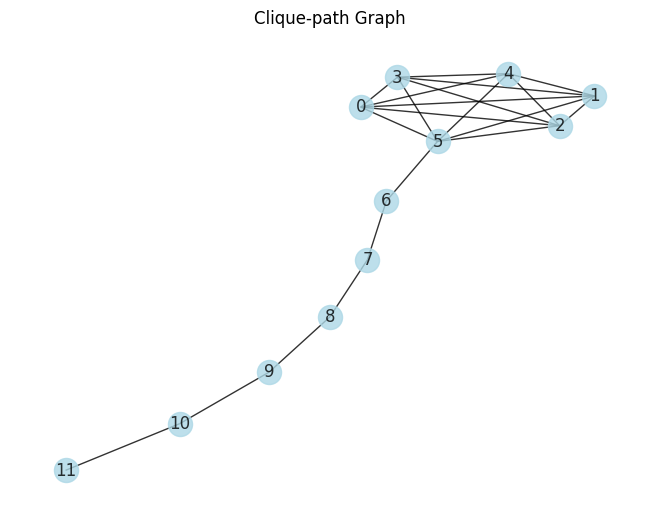

In [4]:
clique_path_graph: nx.Graph = generate_clique_path_graph()
show_graph(clique_path_graph, title = "Clique-path Graph")

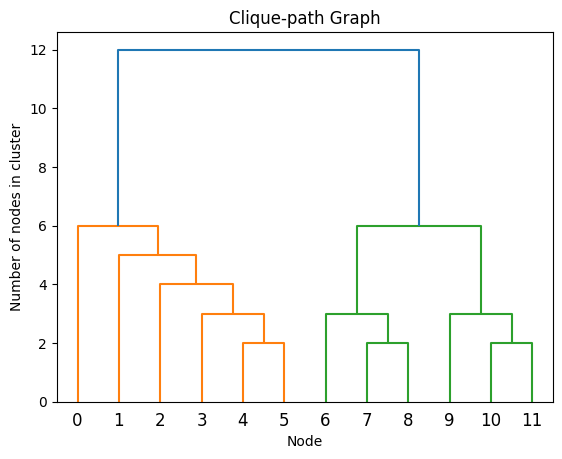

In [5]:
show_dendrogram(clique_path_graph, title="Clique-path Graph")

**Imbalanced Barbell Graph:** This graph is designed to illustrate how networks with really strong natural groups tend to have the same partition regardless of the method used. The graph is really helpful in illustrating what happens when we use a different threshold on the values of the fiedler eigenvector to try and force more "balance" in thepartitions.


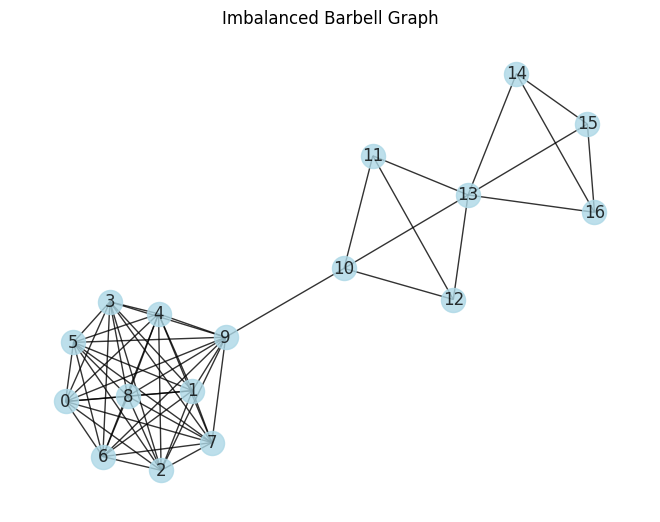

In [6]:
imbalanced_barbell_graph: nx.Graph = generate_imbalanced_barbell_graph()
show_graph(imbalanced_barbell_graph, title="Imbalanced Barbell Graph")

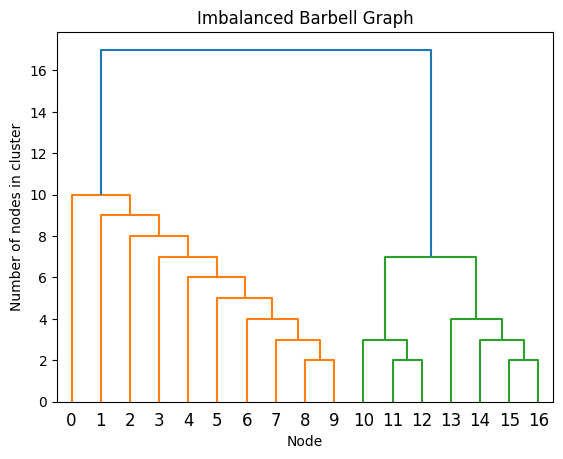

In [7]:
show_dendrogram(imbalanced_barbell_graph, title="Imbalanced Barbell Graph")

**Community Graph:** The community graph generates a set of communities with varying densities and varying bridge widths between communities. It is designed to try and illustrate differences between the three spectral partitioning algorithms, both with and without splitting nodes using the median value of the fiedler eigenvector.

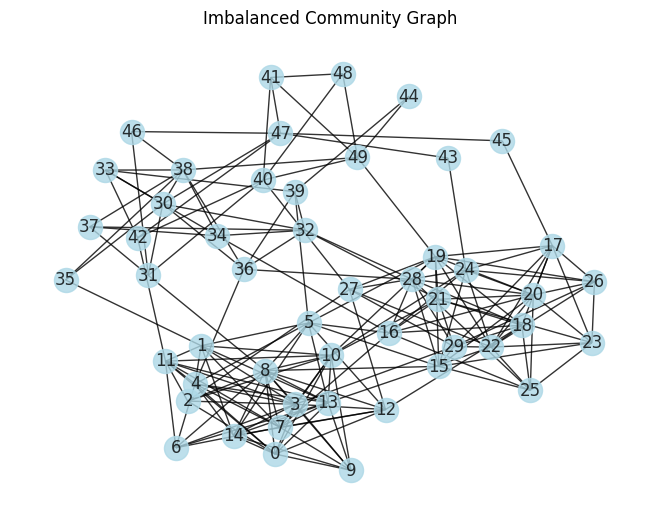

In [8]:
imbalanced_community_graph: nx.Graph = generate_imbalanced_community_based_graph()
show_graph(imbalanced_community_graph, title="Imbalanced Community Graph")

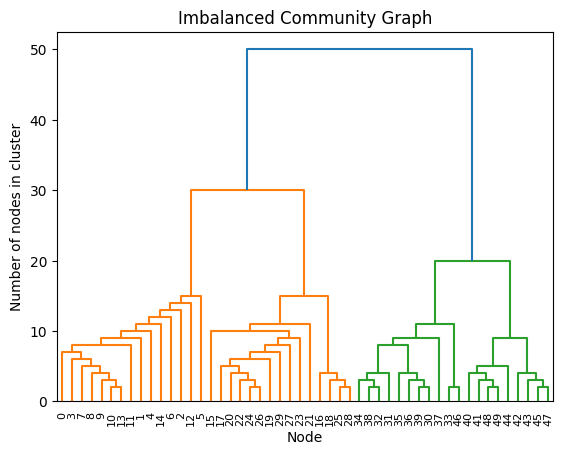

In [9]:
show_dendrogram(imbalanced_community_graph, title="Imbalanced Community Graph")

**Clique-Path-Bridge Graph:** This graph differs from the clique-path graph by adding a wider bridge between the clique and the bridge. It is designed to illustrate the differences between the zero-threshold and the median-threshold methods for splitting vertices by the value of the fiedler eigenvector.

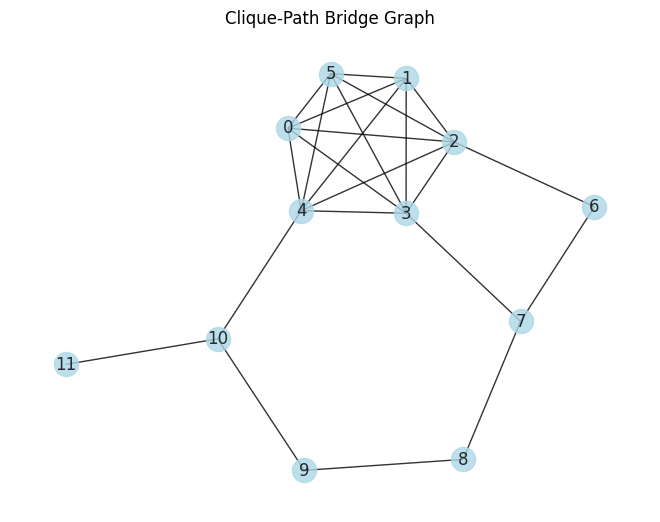

In [10]:
clique_path_bridge_graph: nx.Graph = generate_clique_plus_path_plus_bridge_graph()
show_graph(clique_path_bridge_graph, title="Clique-Path Bridge Graph")

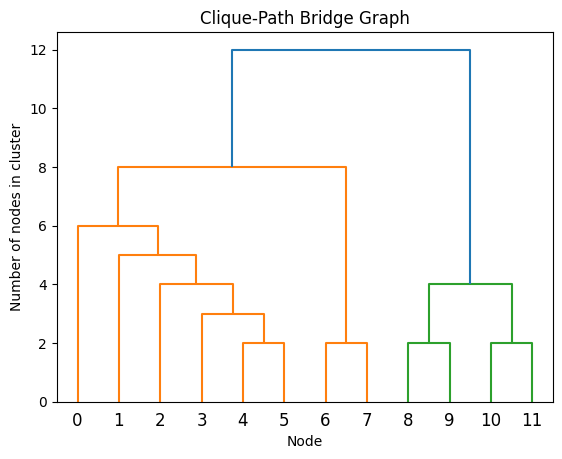

In [11]:
show_dendrogram(clique_path_bridge_graph, title="Clique-Path Bridge Graph")

---
---

### Comparison of different splitting techniques

Let's look at the splits using the various techniques. We'll import the different splitting techniques. Note the following types of functions:
- Implementations from the theory
  - `laplacian_graph_cut`
  - `randomwalk_laplacian_graph_cut`
  - `normalized_laplacian_graph_cut`
- Implementations that use sparse arrays and that are more numerically stable
  - `laplacian_graph_cut_sparse`
  - `randomwalk_laplacian_graph_cut_sparse`
  - `normalized_laplacian_graph_cut_sparse`
- A function that splits the vertex set in a way different from the theory.

We'll discuss the last function after we explore the different algorithms. I'll show results using the methods that are more numerically stable, but want you to be aware of the other methods since you'll use them in the homework.

In [12]:
from partitioning_utilities import laplacian_graph_cut
from partitioning_utilities import normalized_laplacian_graph_cut
from partitioning_utilities import randomwalk_laplacian_graph_cut
from partitioning_utilities import laplacian_graph_cut_sparse
from partitioning_utilities import normalized_laplacian_graph_cut_sparse
from partitioning_utilities import randomwalk_laplacian_graph_cut_sparse
from partitioning_utilities import get_shores_from_eigenvector_median


---
---

#### Clique path graph

In [13]:
G = clique_path_graph

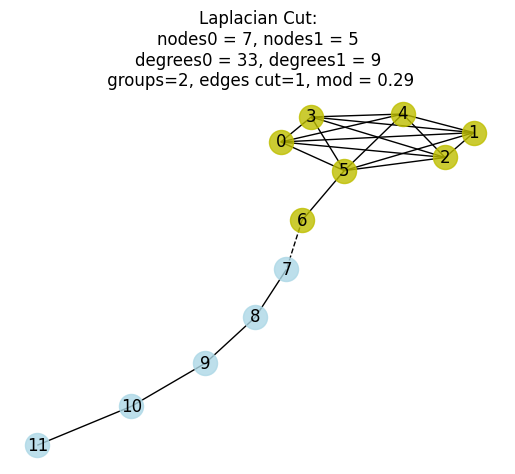

In [14]:
partition = sorted(laplacian_graph_cut_sparse(G), key=min)
title: str = "Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

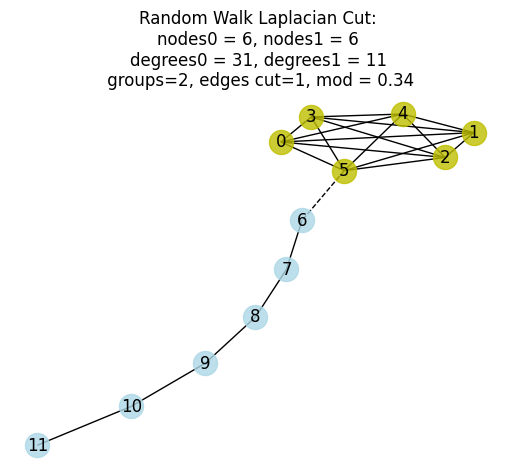

In [15]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G), key=min)
title: str = "Random Walk Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

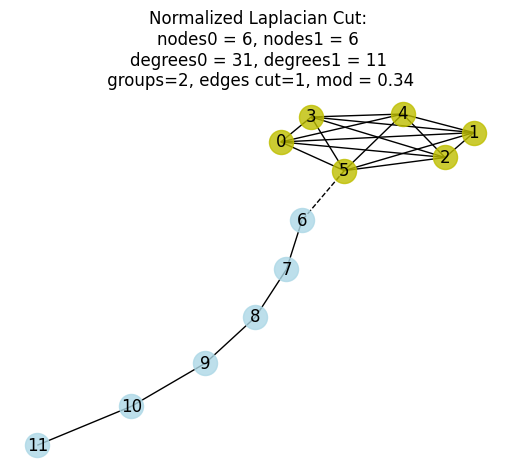

In [16]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G), key=min)
title: str = "Normalized Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

The clique-path graph illustrates what happens when we strengthen how the notion of "balance" is implemented. Balance is defined for each method as follows:
- Laplacian: Enforce the constraint ${\mathbf 1}^T{\mathbf x}$ which tries to make the values of the fiedler eigenvector split so that the sum of the values is one
- Random Walk Laplacian: Enforce balance by changing the minimization criterion from just counting the number of edges cut to include both the number of edges cut and the number of nodes that go into each shore
- Normalized Laplacian: Enforce balance by changing the minimization criterion from just counting the number of edges to include both the number of edges cut and the total degree of the nodes within each shore

See the class slides for the definitions.

The lesson from the clique-path graph is that making balance constraints more explicit in the random walk and normalized methods can shift which edge is cut to make the number of nodes and the total degree in each node closer. No edges from the normalized clique are cut because that increases the cost more than what can be compensated for by increaseing the total degree in the group containing the path. 

---

#### Imbalanced barbell graph

In [17]:
G = generate_imbalanced_barbell_graph()

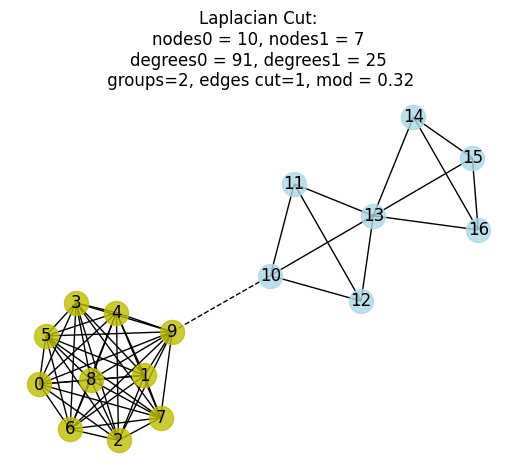

In [18]:
partition = sorted(laplacian_graph_cut_sparse(G), key=min)
title: str = "Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

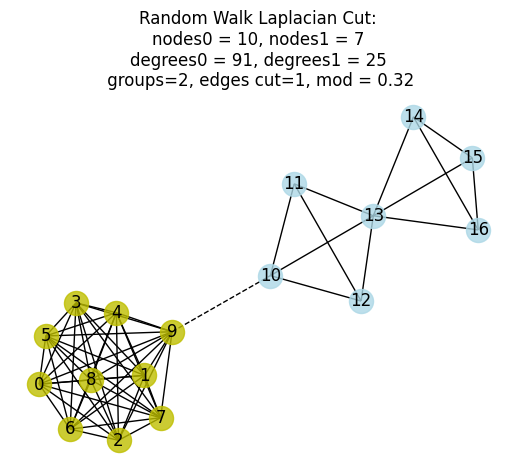

In [19]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G), key=min)
title: str = "Random Walk Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

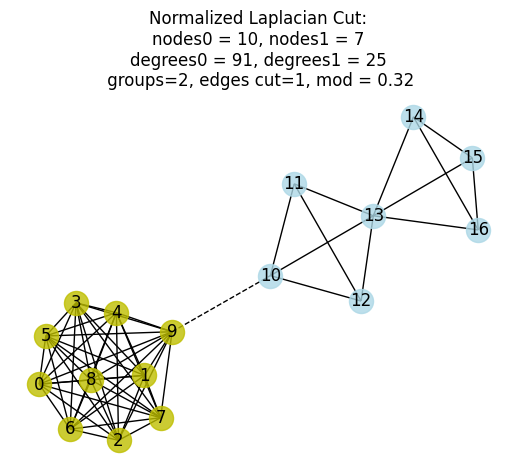

In [20]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G), key=min)
title: str = "Normalized Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

The lesson from the imbalanced barbell graph is that all three Laplacian-based spectral cut methods include the goal of minimizing the number of edges cut. The desire to split nodes into equal sized groups or into groups of equal total degree might not influence the cut if changing the cut will add a lot more cut edges.

---

#### Clique-Path-Bridge Graph

In [21]:
G = clique_path_bridge_graph

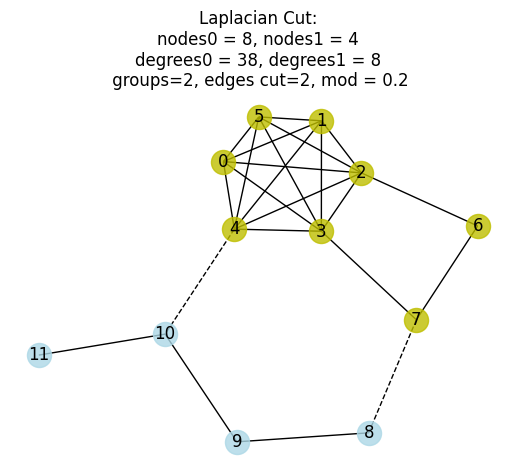

In [22]:
partition = sorted(laplacian_graph_cut_sparse(G), key=min)
title: str = "Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

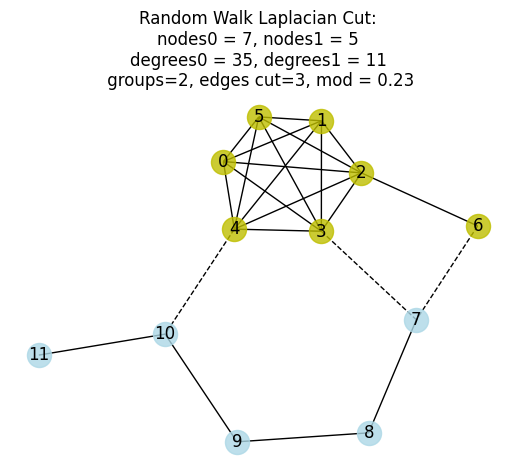

In [23]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G), key=min)
title: str = "Random Walk Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

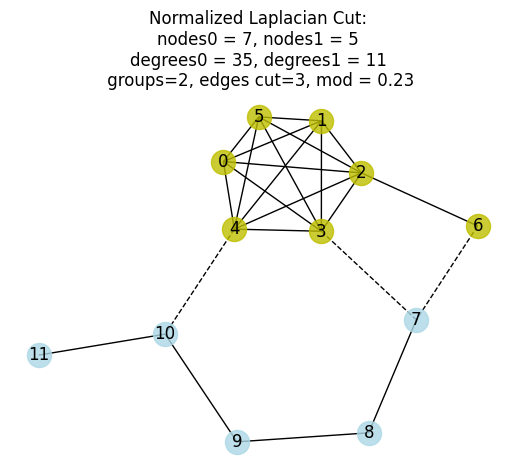

In [24]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G), key=min)
title: str = "Normalized Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

The lesson from the clique-path-bridge graph is that the spectral cuts can be frustratingly oblivious to solutions that can be obvious. You can see that the random walk and normalized Laplacian splits do a better job of balancing the number of nodes and the total degree in across groups in the partition than the simple Laplacian, albeit at an increase in the number of edges cut from two to threee. You can also see that if the cut had been between vertices 2 and 6 instead of between vertices 6 and 7 then the number nodes in each group and the total degree in each partition would have increased without increasing the number of edges cut. We'll return to this problem later in this notebook.

---

#### Imbalanced Communities Graph

In [25]:
G = imbalanced_community_graph

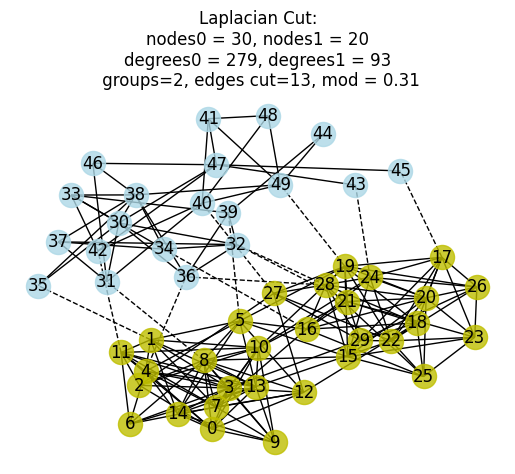

In [26]:
partition = sorted(laplacian_graph_cut_sparse(G), key=min)
title: str = "Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

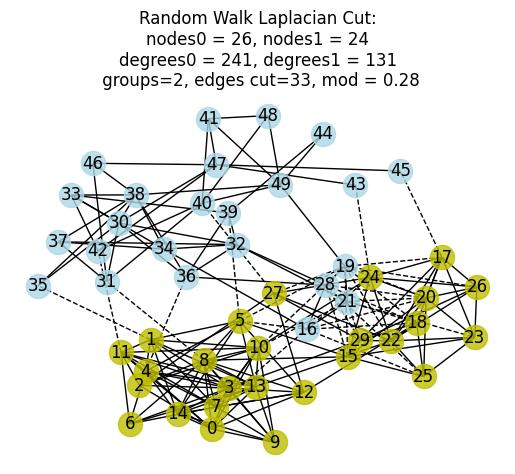

In [27]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G), key=min)
title: str = "Random Walk Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

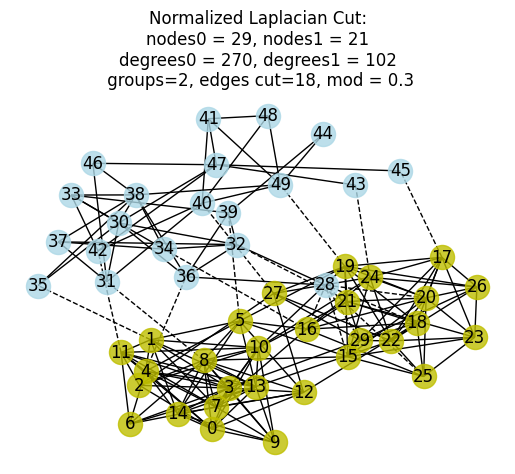

In [28]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G), key=min)
title: str = "Normalized Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

The lesson from the imbalanced commmunities graph is that enforcing balance by adding things to the minimization criterion tends to succeed, but there is going to be some subjective judgment involved in choosing which criteria to use. Observer that the normalized Laplacian split actually has a less balanced total degree across groups than the random walk split. 

Do not conclude from this that the random walk-based split is better; most of the things that I've read indicate that the normalized Laplacian is better. One reason that normalized Laplacian split is considered better is that it is more numerically stable. I haven't studied the numerical stability of the different algorithms enough to understand why, but it's a point worth remembering.

---

### Median-Based Threshold

The spectral-based approximation to the graph cut problem tried to assign vertices to one of two shores. The shores were designated as the $+1$ shore and the $-1$ shore because that allowed the minimization problem to be set up without using the Kronecker delta function. The shore of node $i$ was denoted by $s_i$. 

Since we weren't aboe to solve the minimization problem ${\mathbf s}^TL{\mathbf s}$ problem directly, we solved the real-valued problem ${\mathbf x}^TL{\mathbf x}$ instead. Doing so is an approximation, but we did our best to justify this approximation using the rule

$$ s_i = 
    \left\{
        \begin{array}{ll}
            +1 & {\rm if\ } x_i > 0 \\
            -1 & {\rm if\ } x_i < 0 \\
            \pm 1 & {\rm if\ } x_i = 0
        \end{array}
    \right.
$$

The justification for this rule is that it minimized the angle between the fiedler eigenvector ${\mathbf x}$ and the shore vector ${\mathbf s}$. Minimizing the angle is usually a good solution to this kind of problem, but it doesn't actually try to compensate for errors that might occur when we substitute real-values $x_i$ so we can find $s_i$.

An alternative is to include the idea of balance when we assign the real values of the fiedler eigenvector to shores. One way to do this is to note that we can compute the _median_ value of the rows in the fiedler eigenvector. Denote this median value by $\overline{x}$. We can then use the "median value threshold" rule to assign vertices to shores

$$ s_i = 
    \left\{
        \begin{array}{ll}
            +1 & {\rm if\ } x_i > \overline{x} \\
            -1 & {\rm if\ } x_i < \overline{x} \\
            \pm 1 & {\rm if\ } x_i = \overline{x}
        \end{array}
    \right.
$$

This rule adds the idea of balance back in because it says that we'd want about half of the vertices in each shore, so choosing the median value as the threshold would split the vertices in half. However, the median value also accounts for asymmetric distributions of values in ${\mathbf x}$, so it might not be too restrictive. 

Let's see how it works on the clique-path-bridge graph. In the code, notice how I pass in a method to assign shores to the nodes using the median value rule.

In [29]:
G = clique_path_bridge_graph

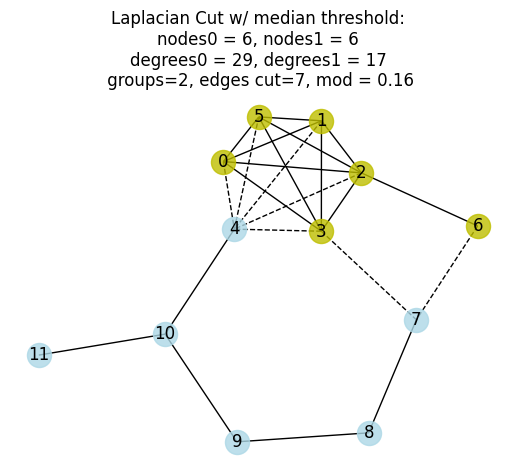

In [30]:
partition = sorted(laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

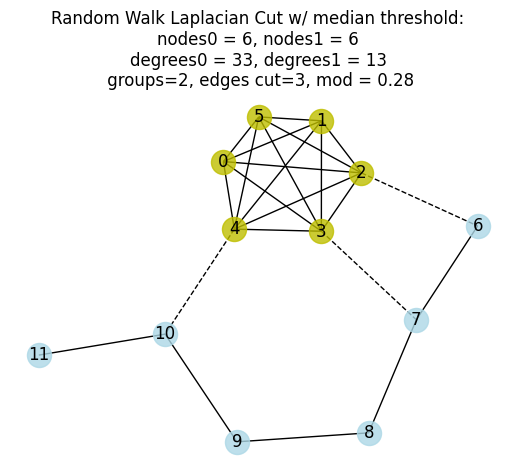

In [31]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Random Walk Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

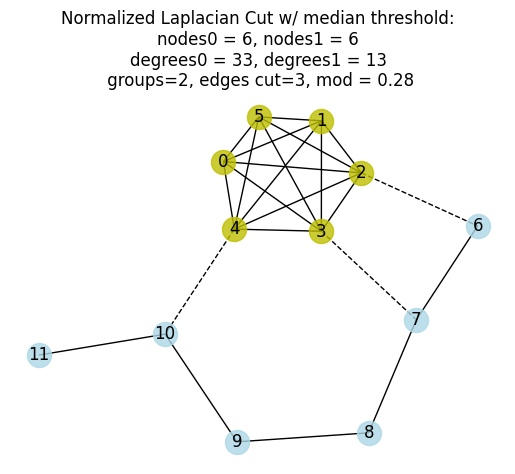

In [32]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Normalized Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

Notice how both the Laplacian and the random-walk Laplacian splits now assign six vertices to each shore. However, this comes at a cost of a lot more edges cut. It's not a great move to put vertex 4 into the same shore as the vertices on the path graph.

The normalized Laplacian split does much better. It successfully moves vertex 6 into the same shore as the other vertices in the path graph while keeping the number of edges cut at three.

Unfortunately, the median-value threshold rule can be really aggressive at assigning vertices to force balance, as illustrated by applying the rule to the imbalanced barbell graph. I'll also show the split for the imbalanced commmunities graph, but I'll let you draw your own conclusions about how well the split works for that graph.

In [33]:
G = imbalanced_barbell_graph

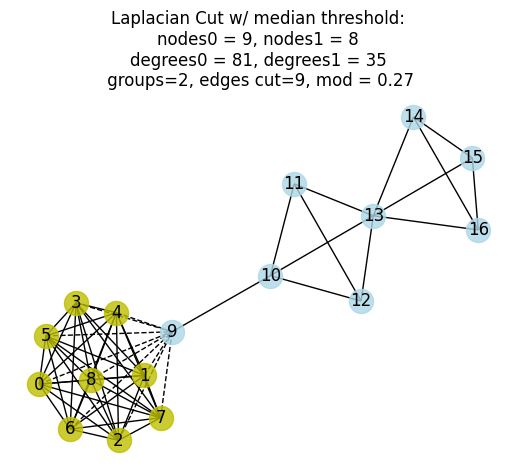

In [34]:
partition = sorted(laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

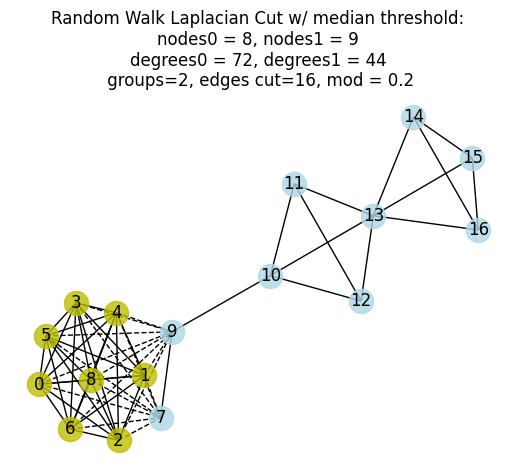

In [35]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Random Walk Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

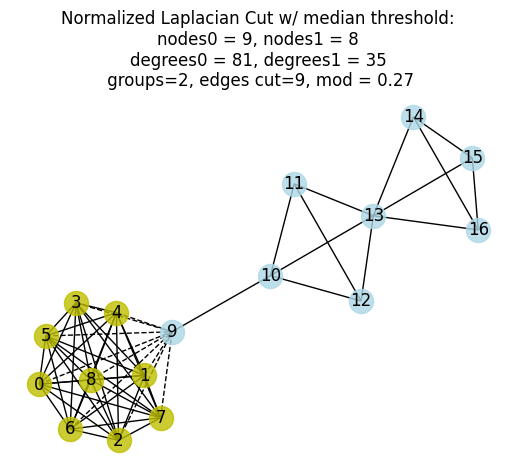

In [36]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Normalized Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

I'd argue that the median value threshold is overly agressive for a graph with such strong communities. Again, we are left with the conclusions that there is an element of subjectivity in choosing which spectral method to use.

---

In [37]:
G = imbalanced_community_graph

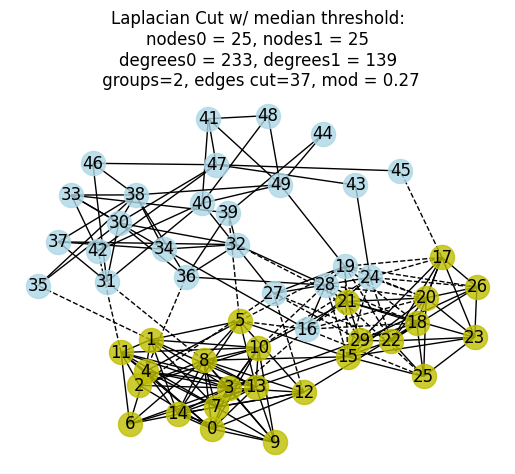

In [38]:
partition = sorted(laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

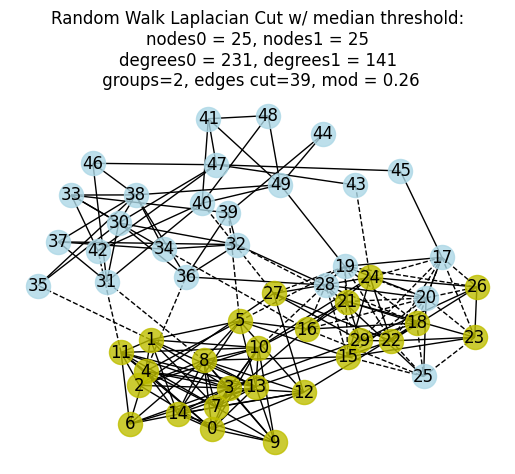

In [39]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Random Walk Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

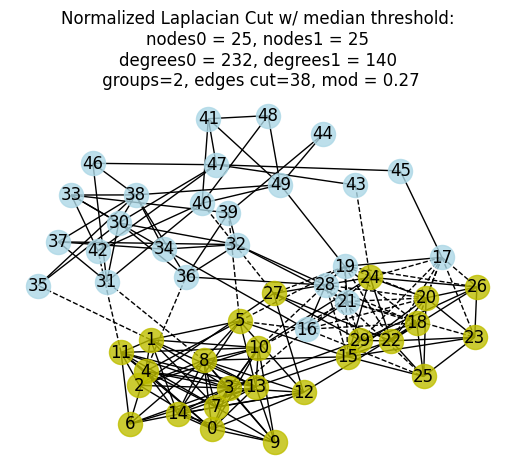

In [40]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
title: str = "Normalized Laplacian Cut w/ median threshold:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

---
---

### Beyond Binary Partitions

The examples above only explored splitting the vertices into two groups. When we want more groups, we can recursively or iteratively split the largest group in two using the code below. I have you experiment with iterative splits in the homework.

See the note after the code for an approach for splitting into more than two groups. The proposed approach is akin to generalizing the median threshold split.

In [41]:
from typing import Hashable, List, Set
from typing import Callable as function

def sub_partition(G: nx.Graph,
                  partition: List[Set[Hashable]],
                  partition_method: function
                  ) -> List[Set[Hashable]]:
    """ 
        Input: 
            • a networkx Graph
            • a list of subsets of the nodes in the graph that partition the nodes
            • a function that can be used to partition the nodes
        Algorithm:
            • find the group in the partition that has the most nodes
            • copy the remaining groups from that partition into a new partition
            • split the largest group by creating the subgraph and calling the partition function
            • add the newly formed subsets of the split group to the new partition

    """
    # make sure groups actually form a partition of G.nodes
    if set(G.nodes()) != set().union(*partition):  # The * unpacks the list
        raise ValueError("partition doesn't include all nodes in the graph")
    # find largest group
    largest_group: Set[Hashable] = max(partition, key=len)
    # new partition = the old minus the largest group
    new_partition: List[Set[Hashable]] = list(s for s in partition if s != largest_group)
    # form subgraph made up of largest group
    graph_of_partition: nx.Graph = nx.Graph(G.subgraph(largest_group))
    # partition the subgraph
    sub_partition = partition_method(graph_of_partition)
    # add the new grups from the subgraph into the new partition
    new_partition.extend(sub_partition)
    return new_partition

In [42]:
G = imbalanced_community_graph


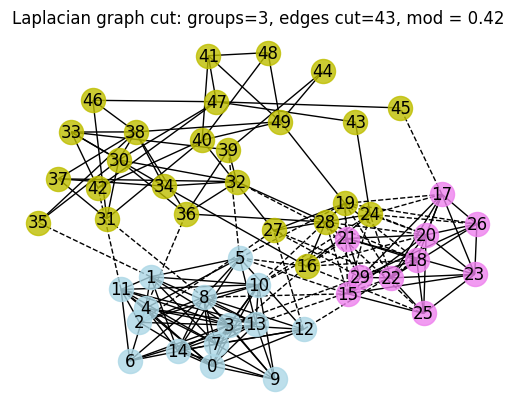

In [43]:
partition = sorted(laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
while len(partition) < 3:
    partition = sub_partition(G, partition, partition_method=laplacian_graph_cut_sparse) 
show_partitions(G, 
                partition, 
                title="Laplacian graph cut:")

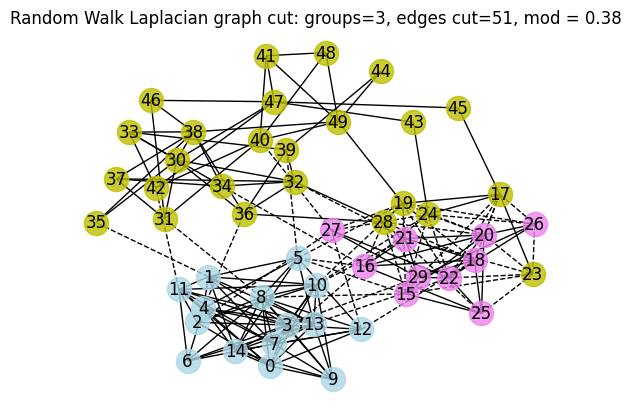

In [44]:
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
while len(partition) < 3:
    partition = sub_partition(G, partition, partition_method=randomwalk_laplacian_graph_cut_sparse) 
show_partitions(G, 
                partition, 
                title="Random Walk Laplacian graph cut:")

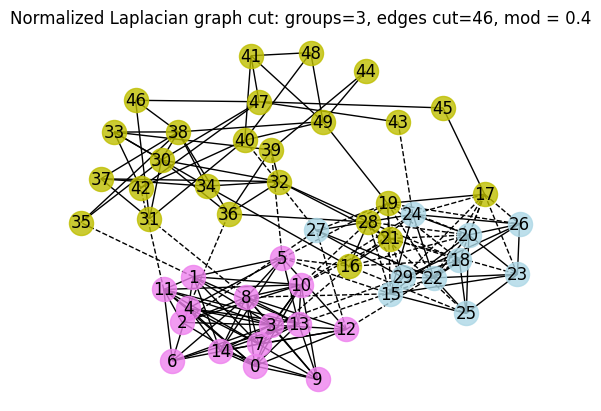

In [45]:
partition = sorted(normalized_laplacian_graph_cut_sparse(G, get_shores=get_shores_from_eigenvector_median), key=min)
while len(partition) < 3:
    partition = sub_partition(G, partition, partition_method=normalized_laplacian_graph_cut_sparse) 
show_partitions(G, 
                partition, 
                title="Normalized Laplacian graph cut:")

The median threshold rule split the vertices into shores by finding the median value of the rows of the fiedler eigenvector and splitting at that value. We could generalize this, motivated by the lousy job done by iteratively applying a binary split. The generalization would be to split the values of the fiedler eigenvector into three and then assign the nodes to one of three groups in the partition depending on which cluster of values they belong to. 

That is a nice segue to something that we'll do shortly in the class: use clustering methods to partition vertices. Clustering methods use features of the nodes, which is a nice first use of node features in the portion of the class on graph data science.

---
---

## References

One of the problems that I encountered was that when the "natural groups" weren't well-balanced, the zero-threshold way of assigning nodes to groups worked poorly. ChatGPT helped me discover median-based methods, and helped me find the following papers

### **Spectral Clustering & Graph Cuts**
- **Von Luxburg, U. (2007).** *A Tutorial on Spectral Clustering.*  
  *Statistics and Computing, 17(4), 395–416.*  
  [DOI: 10.1007/s11222-007-9033-z](https://doi.org/10.1007/s11222-007-9033-z)  
  - Explains spectral clustering methods and when different thresholding techniques (zero-based vs. median) are useful.

- **Chung, F. (1997).** *Spectral Graph Theory.*  
  *CBMS Regional Conference Series in Mathematics, Vol. 92.*  
  [Link](https://www.ams.org/cbms/092)  
  - A fundamental resource on the properties of the Laplacian and its eigenvectors, including the Fiedler vector.

### **Normalized vs. Random Walk Laplacians**
- **Shi, J., & Malik, J. (2000).** *Normalized Cuts and Image Segmentation.*  
  *IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(8), 888–905.*  
  [DOI: 10.1109/34.868688](https://doi.org/10.1109/34.868688)  
  - Demonstrates how different Laplacian matrices affect clustering and segmentation.

- **Ng, A., Jordan, M., & Weiss, Y. (2002).** *On Spectral Clustering: Analysis and an Algorithm.*  
  *Advances in Neural Information Processing Systems (NeurIPS).*  
  [Link](https://proceedings.neurips.cc/paper_files/paper/2002/file/1f71e393b3809197ed3d06a91695e054-Paper.pdf)  
  - Discusses the differences between the standard Laplacian, normalized Laplacian, and random walk Laplacian.

### **Empirical Considerations in Real-World Graphs**
- **Spielman, D. A., & Teng, S. (1996).** *Spectral Partitioning Works: Planar Graphs and Beyond.*  
  *IEEE Symposium on Foundations of Computer Science (FOCS).*  
  [DOI: 10.1109/SFCS.1996.548458](https://doi.org/10.1109/SFCS.1996.548458)  
  - Provides theoretical and empirical justification for using spectral methods in different types of graphs.

- **Newman, M. E. J. (2018).** *Networks: An Introduction.*  
  *Oxford University Press.*  
  [ISBN: 9780198805090](https://global.oup.com/academic/product/networks-9780198805090)  
  - Covers applications of spectral methods and their real-world interpretations.

---

Some figures for slides

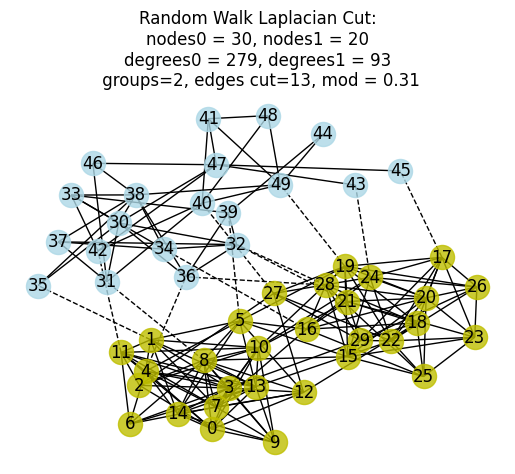

In [46]:
G = imbalanced_community_graph
partition = sorted(randomwalk_laplacian_graph_cut_sparse(G), key=min)
title: str = "Random Walk Laplacian Cut:"
title += f"\nnodes0 = {len(partition[0])}, nodes1 = {len(partition[1])}"
group0_degree: int = sum(G.degree(node) for node in partition[0])
group1_degree: int = sum(G.degree(node) for node in partition[1])
title += f"\ndegrees0 = {group0_degree}, degrees1 = {group1_degree}\n"
show_partitions(G, 
                partition, 
                title=title)

In [47]:
import numpy as np
from numpy.typing import NDArray
from partitioning_utilities import get_fiedler_eigenvector_sparse
x: NDArray[np.float64] = get_fiedler_eigenvector_sparse(nx.laplacian_matrix(G))
y = x.tolist()
rounded_y = [float(np.round(val, 2)) for val in y]
print(sorted(rounded_y))

[-0.14, -0.14, -0.14, -0.13, -0.13, -0.13, -0.13, -0.13, -0.12, -0.12, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.11, -0.1, -0.1, -0.1, -0.1, -0.1, -0.09, -0.09, -0.08, -0.08, -0.08, -0.07, -0.07, -0.07, 0.05, 0.06, 0.08, 0.08, 0.08, 0.1, 0.11, 0.14, 0.14, 0.14, 0.15, 0.15, 0.16, 0.18, 0.21, 0.22, 0.23, 0.29, 0.3, 0.34]


In [48]:
percentiles = np.percentile(rounded_y, [33, 67])
print(percentiles)

[-0.1083  0.08  ]


In [49]:
from typing import Tuple
from scipy.sparse import diags
def get_shores_from_eigenvector_triples(G: nx.Graph
                                        ) -> Tuple[Set[Hashable], Set[Hashable], Set[Hashable]]:
    """
        Partitions nodes into two sets based on the median of the Fiedler eigenvector.
        Generated by chatGPT in response to prompts about how to improve partitioning
    """
    L = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).astype(float)

    # Compute Degree Matrix (Sparse D⁻¹)
    degrees = np.array([G.degree(node) for node in sorted(G.nodes())], dtype=float)
    degrees[degrees == 0] = 1  # Avoid division by zero
    D_inv = diags(1.0 / degrees)  # Sparse D^(-1)

    # Compute Random Walk Laplacian: L_rw = D⁻¹ L
    L_rw = D_inv @ L  # Sparse matrix multiplication

    # Compute Fiedler Eigenvector
    v = get_fiedler_eigenvector_sparse(L_rw)
    y = v.tolist()
    rounded_y = [float(np.round(val, 2)) for val in y]
    
    percentiles = np.percentile(rounded_y, [33, 67])

    nodes = sorted(G.nodes())  # Ensure consistent ordering

    shore1 = {nodes[i] for i in range(len(nodes)) if v[i] < percentiles[0]}
    shore2 = {nodes[i] for i in range(len(nodes)) if v[i] >= percentiles[0] and v[i] < percentiles[1]}
    shore3 = set(G.nodes()) - shore1 - shore2

    return shore1, shore2, shore3

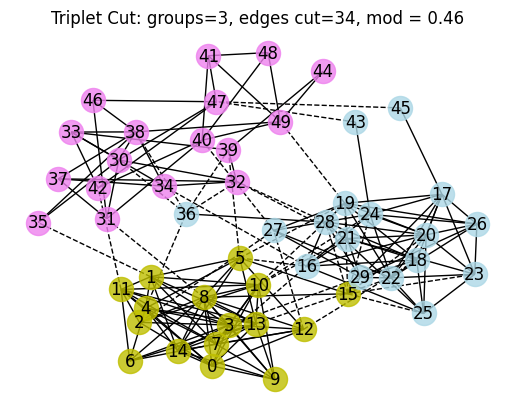

In [50]:
partition = sorted(get_shores_from_eigenvector_triples(G), key=min)
title: str = "Triplet Cut:"
show_partitions(G, 
                partition, 
                title=title)